Nama  : Muhammad Bagas Kurnia\
NIM   : 121450051\
KElas : RA

# Pendahuluan
Pada artikel tersebut terdapat tiga cara utama yaitu dengan format PNG, lightning memory-mapped databases (LMDB), dan dengan hierarchical data format (HDF5) yang digunakan dalam melakukan storing dan pengaksesan images dengan menggunakan python. Langkah-langkah eksperimental dilakukan, termasuk persiapan, penyimpanan satu gambar, penyimpanan banyak gambar, membaca satu gambar, membaca banyak gambar, dan evaluasi. Fokus utama artikel ini adalah membandingkan proses penyimpanan dan pengaksesan gambar menggunakan ketiga metode tersebut.

Dalam langkah persiapan, digunakan dataset gambar yang berasal dari Canadian Institute for Advanced Research (CIFAR-10). Dataset ini terdiri dari 60.000 gambar berwarna dengan dimensi 32x32 piksel.

In [ ]:
import numpy as np
import pickle
from pathlib import Path

# Path to the unzipped CIFAR data
data_dir = Path("C:/Users/mbgsk/Downloads/cifar-10-batches-py")

# Unpickle function provided by the CIFAR hosts
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

images, labels = [], []
for batch in data_dir.glob("data_batch_*"):
    batch_data = unpickle(batch)
    for i, flat_im in enumerate(batch_data[b"data"]):
        im_channels = []
        # Each image is flattened, with channels in order of R, G, B
        for j in range(3):
            im_channels.append(
                flat_im[j * 1024 : (j + 1) * 1024].reshape((32, 32))
            )
        # Reconstruct the original image
        images.append(np.dstack((im_channels)))
        # Save the label
        labels.append(batch_data[b"labels"][i])

print("Loaded CIFAR-10 training set:")
print(f" - np.shape(images)     {np.shape(images)}")
print(f" - np.shape(labels)     {np.shape(labels)}")

Loaded CIFAR-10 training set:
 - np.shape(images)     (50000, 32, 32, 3)
 - np.shape(labels)     (50000,)


Ada banyak cara untuk mengakses dan menyimpan data, terutama data gambar, di Python. Library PIL memungkinkan pemrosesan dan pemodelan data gambar, bahkan hingga ratusan gambar. Namun, semakin besar volume data, semakin tinggi beban kerja algoritma. Untuk menangani volume data yang besar, terutama dalam pelatihan model seperti Convolutional Neural Networks (CNN), diperlukan pendekatan yang efisien. Salah satu kendala yang dihadapi adalah waktu yang dibutuhkan untuk memuat data yang sangat besar ke dalam memori untuk pelatihan. Pemrosesan dalam batch bisa memakan waktu yang signifikan dan kurang efisien.

Setup for Storing Images on Disk

1.LMDB\
Keunggulan utama LMDB terletak pada kemampuannya memetakan file langsung ke dalam memori, sehingga mengembalikan penunjuk langsung ke alamat memori dari kunci dan nilai, tanpa perlu menyalin data di dalam memori seperti yang umumnya dilakukan oleh basis data lain.\
2.HDF5\
File HDF terdiri dari kumpulan data yang mencakup array multidimensi (dapat menyimpan array dengan ukuran dan tipe data apa pun) dan grup yang merupakan koleksi dari kumpulan data tersebut.\

In [ ]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: C:\Users\mafad\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
pip install h5py


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: C:\Users\mafad\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



     ---------------------------------------- 3.0/3.0 MB 999.8 kB/s eta 0:00:00


In [ ]:
pip install lmdb

     -------------------------------------- 105.9/105.9 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: C:\Users\mafad\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Menyimpan Satu Gambar
 Karena lima kumpulan CIFAR-10 berjumlah 50.000 gambar, dapat digunakan setiap gambar dua kali untuk mendapatkan 100.000 gambar. dan memerlukan folder untuk menyimpan file gambar dan path direktori dari ketiga variabel,syntax untuk menyimpan gambar sebagai berikut

In [ ]:
from pathlib import Path

disk_dir = Path("data/disk/")
lmdb_dir = Path("data/lmdb/")
hdf5_dir = Path("data/hdf5/")

In [ ]:
disk_dir.mkdir(parents=True, exist_ok=True)
lmdb_dir.mkdir(parents=True, exist_ok=True)
hdf5_dir.mkdir(parents=True, exist_ok=True)

# Menyimpan ke disk
Gambar yang sebelumya terdapat dalam memory dalam bentuk numpy array akan disimpan ke disk sebagai format png.

In [ ]:
from PIL import Image
import csv

def store_single_disk(image, image_id, label):
    """ Stores a single image as a .png file on disk.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    Image.fromarray(image).save(disk_dir / f"{image_id}.png")

    with open(disk_dir / f"{image_id}.csv", "wt") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        writer.writerow([label])

salah satu solusi untuk menyumpan gambar ke dalam disk dan hanya menyimpan metadata yang terkait adalah dengan mengkodekan metadata tersebut ke dalam file gambar. langkah ini dapat menghilangkan kebutuhan untuk menyimpan metadata dalam file terpisah.

# Menyimpan dalam LMBD
LMDB adalah sistem penyimpanan di mana setiap entri disimpan sebagai array byte. Dalam kasus ini, setiap gambar akan memiliki pengidentifikasi unik sebagai kunci, dan gambar itu sendiri akan menjadi nilai. Keduanya harus berupa string.dapat  menggunakan library "pickle" untuk melakukan serialisasi. Dengan cara ini, semua objek Python bisa diserialisasi, sehingga direkomendasikan untuk menyertakan metadata gambar dalam basis data.\

cara ini membantu menghindari kesulitan dalam menyematkan kembali metadata ke gambar saat memuat kumpulan data dari disk. Berikut adalah contoh kode untuk membuat kelas untuk gambar dan metadata-nya.

In [ ]:
class CIFAR_Image:
    def __init__(self, image, label):
        # Dimensions of image for reconstruction - not really necessary
        # for this dataset, but some datasets may include images of
        # varying sizes
        self.channels = image.shape[2]
        self.size = image.shape[:2]

        self.image = image.tobytes()
        self.label = label

    def get_image(self):
        """ Returns the image as a numpy array. """
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.size, self.channels)

Ketika menggunakan LMDB, basis data baru perlu mengetahui perkiraan jumlah memori yang akan digunakan, yang disebut sebagai "map_size", karena LMDB memetakan basis data ke dalam memori. Meskipun sederhana dalam beberapa kasus, ini bisa menjadi masalah dalam situasi tertentu.

berikut kode untuk menyimpan satu gambar dengan LMDB

In [ ]:
import lmdb
import pickle

def store_single_lmdb(image, image_id, label):
    """ Stores a single image to a LMDB.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    map_size = image.nbytes * 10

    # Create a new LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), map_size=map_size)

    # Start a new write transaction
    with env.begin(write=True) as txn:
        # All key-value pairs need to be strings
        value = CIFAR_Image(image, label)
        key = f"{image_id:08}"
        txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

# Menyimpan dengan HDF5
Berikut kode penyimpanan HDF5 dengan dua data.

In [ ]:
import h5py

def store_single_hdf5(image, image_id, label):
    """ Stores a single image to an HDF5 file.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "image", np.shape(image), h5py.h5t.STD_U8BE, data=image
    )
    meta_set = file.create_dataset(
        "meta", np.shape(label), h5py.h5t.STD_U8BE, data=label
    )
    file.close()

# Eksperimen untuk Menyimpan Satu Gambar
Dibuat sebuah dictionary yang mencakup 3 teknik penyimpanan gambar

In [ ]:
_store_single_funcs = dict(
    disk=store_single_disk, lmdb=store_single_lmdb, hdf5=store_single_hdf5
)

In [ ]:
from timeit import timeit

store_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_store_single_funcs[method](image, 0, label)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    store_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.14101860000000244
Method: lmdb, Time usage: 0.0030824999999978786
Method: hdf5, Time usage: 0.00663929999999624


dihasilakn metode Disk memakan waktu 0.14101860000000244 detik, LMBD selama 0.0030824999999978786 detik dan HDF5 selama 0.00663929999999624 detik.

# Menyimpan Banyak Gambar
Untuk melakukan menyimpan banyak gambar dilakukan pengkodean sebagai berikut.

In [ ]:
def store_many_disk(images, labels):
    """ Stores an array of images to disk
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Save all the images one by one
    for i, image in enumerate(images):
        Image.fromarray(image).save(disk_dir / f"{i}.png")

    # Save all the labels to the csv file
    with open(disk_dir / f"{num_images}.csv", "w") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for label in labels:
            # This typically would be more than just one value per row
            writer.writerow([label])

def store_many_lmdb(images, labels):
    """ Stores an array of images to LMDB.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    map_size = num_images * images[0].nbytes * 10

    # Create a new LMDB DB for all the images
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), map_size=map_size)

    # Same as before — but let's write all the images in a single transaction
    with env.begin(write=True) as txn:
        for i in range(num_images):
            # All key-value pairs need to be Strings
            value = CIFAR_Image(images[i], labels[i])
            key = f"{i:08}"
            txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

def store_many_hdf5(images, labels):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.STD_U8BE, data=images
    )
    meta_set = file.create_dataset(
        "meta", np.shape(labels), h5py.h5t.STD_U8BE, data=labels
    )
    file.close()

melakikan cutoff yang bernilai 10, 100, 1000, 10000, dan 100000 gambar

In [ ]:
cutoffs = [10, 100, 1000, 10000, 100000]

# Let's double our images so that we have 100,000
images = np.concatenate((images, images), axis=0)
labels = np.concatenate((labels, labels), axis=0)

# Make sure you actually have 100,000 images and labels
print(np.shape(images))
print(np.shape(labels))

(100000, 32, 32, 3)
(100000,)


setelah itu melakukan eksperiment untuk menyimpan banyak gambar

In [ ]:
_store_many_funcs = dict(
    disk=store_many_disk, lmdb=store_many_lmdb, hdf5=store_many_hdf5
)

from timeit import timeit

store_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_store_many_funcs[method](images_, labels_)",
            setup="images_=images[:cutoff]; labels_=labels[:cutoff]",
            number=1,
            globals=globals(),
        )
        store_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.01748150000000237
Method: lmdb, Time usage: 0.003559100000003923
Method: hdf5, Time usage: 0.0021229000000033693
Method: disk, Time usage: 0.08811370000000807
Method: lmdb, Time usage: 0.005510099999995077
Method: hdf5, Time usage: 0.0015849999999915099
Method: disk, Time usage: 0.8397192000000047
Method: lmdb, Time usage: 0.030875000000008868
Method: hdf5, Time usage: 0.0026256999999958452
Method: disk, Time usage: 8.7503715
Method: lmdb, Time usage: 0.2223862999999966
Method: hdf5, Time usage: 0.01714979999999855
Method: disk, Time usage: 84.8027426
Method: lmdb, Time usage: 2.7005553999999847
Method: hdf5, Time usage: 0.22156839999999534


penyimpanan gambar disimpan 5 kali. untuk memilih model yang terbaik dapat di lakukan pengecakan dari ketiga metode tersebut pada setiap cutoff, metode yang terbaik ialah metode dengan time usage yang lebih kecil.

C:\Users\mafad\AppData\Local\Temp\ipykernel_23556\2568719458.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


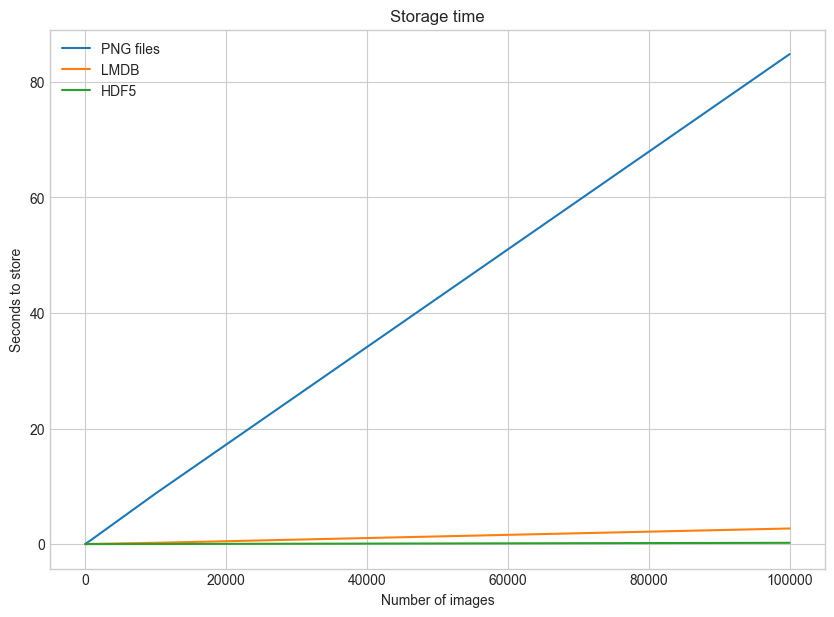

C:\Users\mafad\AppData\Local\Temp\ipykernel_23556\2568719458.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


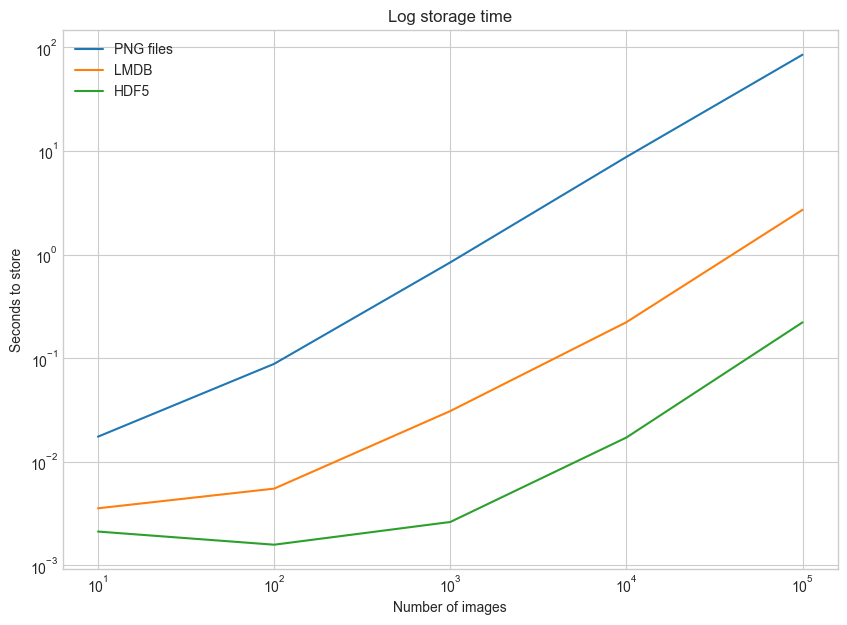

In [ ]:
import matplotlib.pyplot as plt

def plot_with_legend(
    x_range, y_data, legend_labels, x_label, y_label, title, log=False
):
    """ Displays a single plot with multiple datasets and matching legends.
        Parameters:
        --------------
        x_range         list of lists containing x data
        y_data          list of lists containing y values
        legend_labels   list of string legend labels
        x_label         x axis label
        y_label         y axis label
    """
    plt.style.use("seaborn-whitegrid")
    plt.figure(figsize=(10, 7))

    if len(y_data) != len(legend_labels):
        raise TypeError(
            "Error: number of data sets does not match number of labels."
        )

    all_plots = []
    for data, label in zip(y_data, legend_labels):
        if log:
            temp, = plt.loglog(x_range, data, label=label)
        else:
            temp, = plt.plot(x_range, data, label=label)
        all_plots.append(temp)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(handles=all_plots)
    plt.show()

# Getting the store timings data to display
disk_x = store_many_timings["disk"]
lmdb_x = store_many_timings["lmdb"]
hdf5_x = store_many_timings["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Storage time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Log storage time",
    log=True,
)

# Membaca satu gambar
Untuk dapat membaca dari disk dengan format png digunakan syntax berikut

In [ ]:
def read_single_disk(image_id):
    """ Stores a single image to disk.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    image = np.array(Image.open(disk_dir / f"{image_id}.png"))

    with open(disk_dir / f"{image_id}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        label = int(next(reader)[0])

    return image, label

Untuk proses read dengan metode LMBD

In [ ]:
def read_single_lmdb(image_id):
    """ Stores a single image to LMDB.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Encode the key the same way as we stored it
        data = txn.get(f"{image_id:08}".encode("ascii"))
        # Remember it's a CIFAR_Image object that is loaded
        cifar_image = pickle.loads(data)
        # Retrieve the relevant bits
        image = cifar_image.get_image()
        label = cifar_image.label
    env.close()

    return image, label

terkahir untuk metode HDF5

In [ ]:
def read_single_hdf5(image_id):
    """ Stores a single image to HDF5.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "r+")

    image = np.array(file["/image"]).astype("uint8")
    label = int(np.array(file["/meta"]).astype("uint8"))

    return image, label

In [ ]:
_read_single_funcs = dict(
    disk=read_single_disk, lmdb=read_single_lmdb, hdf5=read_single_hdf5
)

dilakukan eksperiment untuk single data

In [ ]:
from timeit import timeit

read_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_read_single_funcs[method](0)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    read_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.010393899999996847
Method: lmdb, Time usage: 0.014496699999995144
Method: hdf5, Time usage: 0.010247699999979432


Didapatkan hasil bahwa proses read gambar dengan metode  Disk menghabiskan waktu 0.010393899999996847 detik, LMBD 0.014496699999995144 detik dan HDF5 0.010247699999979432 detik.

# Membaca Banyak Gambar
Proses pembacaan banyak gamabr dengan syntax berikut

In [ ]:
def read_many_disk(num_images):
    """ Reads image from disk.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Loop over all IDs and read each image in one by one
    for image_id in range(num_images):
        images.append(np.array(Image.open(disk_dir / f"{image_id}.png")))

    with open(disk_dir / f"{num_images}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for row in reader:
            labels.append(int(row[0]))
    return images, labels

def read_many_lmdb(num_images):
    """ Reads image from LMDB.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Read all images in one single transaction, with one lock
        # We could split this up into multiple transactions if needed
        for image_id in range(num_images):
            data = txn.get(f"{image_id:08}".encode("ascii"))
            # Remember that it's a CIFAR_Image object
            # that is stored as the value
            cifar_image = pickle.loads(data)
            # Retrieve the relevant bits
            images.append(cifar_image.get_image())
            labels.append(cifar_image.label)
    env.close()
    return images, labels

def read_many_hdf5(num_images):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "r+")

    images = np.array(file["/images"]).astype("uint8")
    labels = np.array(file["/meta"]).astype("uint8")

    return images, labels

_read_many_funcs = dict(
    disk=read_many_disk, lmdb=read_many_lmdb, hdf5=read_many_hdf5
)

In [ ]:
from timeit import timeit

read_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_read_many_funcs[method](num_images)",
            setup="num_images=cutoff",
            number=0,
            globals=globals(),
        )
        read_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, No. images: {cutoff}, Time usage: {t}")


Method: disk, No. images: 10, Time usage: 3.000000106112566e-07
Method: lmdb, No. images: 10, Time usage: 1.999999312829459e-07
Method: hdf5, No. images: 10, Time usage: 2.0000004496978363e-07
Method: disk, No. images: 100, Time usage: 3.000000106112566e-07
Method: lmdb, No. images: 100, Time usage: 3.000000106112566e-07
Method: hdf5, No. images: 100, Time usage: 3.000000106112566e-07
Method: disk, No. images: 1000, Time usage: 2.0000004496978363e-07
Method: lmdb, No. images: 1000, Time usage: 2.0000004496978363e-07
Method: hdf5, No. images: 1000, Time usage: 2.0000004496978363e-07
Method: disk, No. images: 10000, Time usage: 2.0000004496978363e-07
Method: lmdb, No. images: 10000, Time usage: 2.0000004496978363e-07
Method: hdf5, No. images: 10000, Time usage: 3.000000106112566e-07
Method: disk, No. images: 100000, Time usage: 3.000000106112566e-07
Method: lmdb, No. images: 100000, Time usage: 1.999999312829459e-07
Method: hdf5, No. images: 100000, Time usage: 3.000000106112566e-07


dapat dilihat bahwa metode lmdb lebih cepat membaca image ketimbang metode disk dan hdfs

C:\Users\mafad\AppData\Local\Temp\ipykernel_23556\2568719458.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


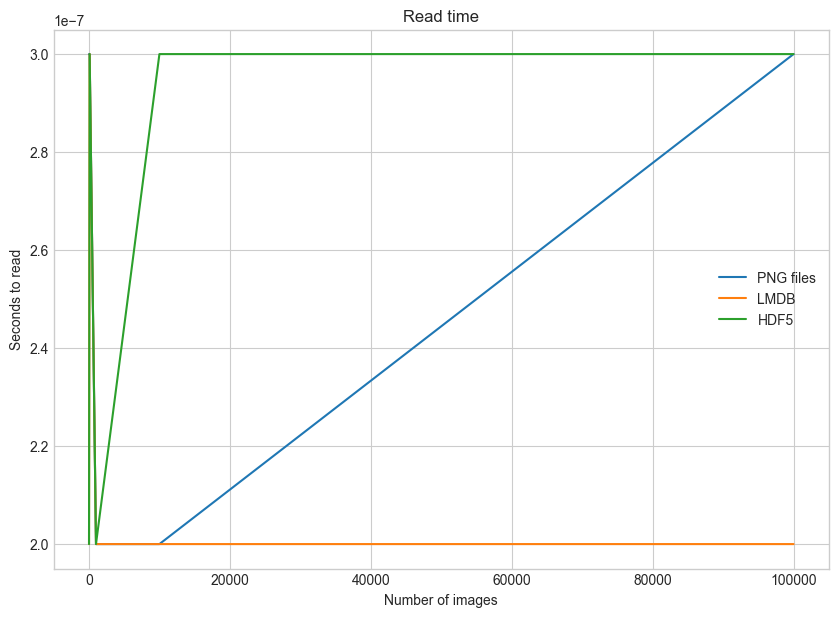

C:\Users\mafad\AppData\Local\Temp\ipykernel_23556\2568719458.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


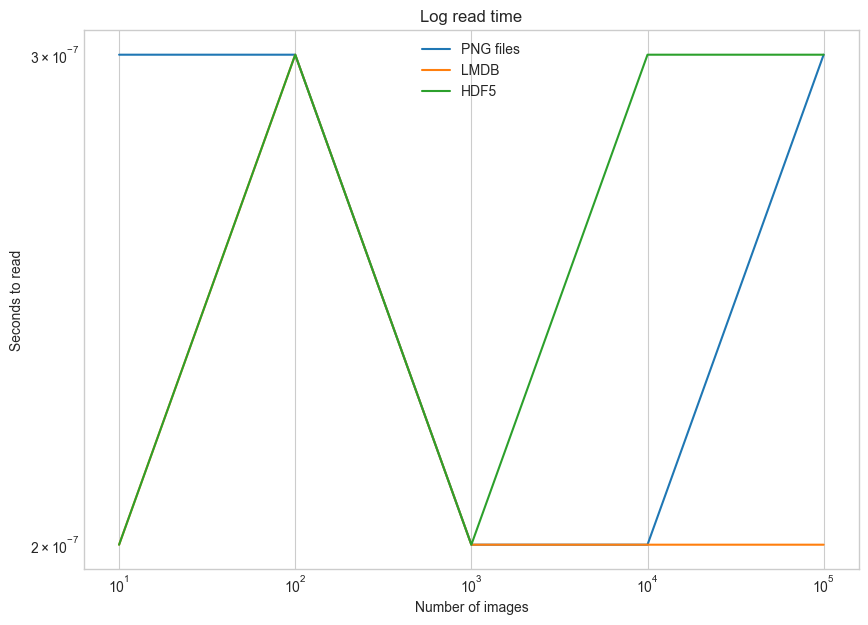

In [ ]:
disk_x_r = read_many_timings["disk"]
lmdb_x_r = read_many_timings["lmdb"]
hdf5_x_r = read_many_timings["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to read",
    "Read time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to read",
    "Log read time",
    log=True,
)

Dari kedua grafik di atas didadpatkan bahwa LMDB kinerjanya seringkali lebih cepat sieiring bertambahnya data yang dibaca

# Kesimpulan
Setiap sistem penyimpanan yaitu format PNG, LMDB, maupun HDF5, memiliki kelemahan tersendiri. Namun, penting untuk diingat bahwa dalam LMDB, data baru ditulis tanpa mengganggu atau memindahkan data yang sudah ada. Pendekatan desain ini tidak hanya memungkinkan operasi pembacaan yang sangat cepat, tetapi juga menjamin integritas dan keandalan data tanpa memerlukan penyimpanan log transaksi tambahan. LMDB mencapai keseimbangan optimal antara kinerja, integritas data, dan keandalan operasi, menjadikannya pilihan yang kuat untuk aplikasi yang membutuhkan akses cepat dan aman terhadap data. Di sisi lain, dalam kondisi kinerja tinggi, penggunaan HDF5 akan sangat bermanfaat.

Secara umum, dalam LMDB, kinerja yang lebih baik dapat diperoleh ketika mengakses item secara berurutan berdasarkan kunci. Ini disebabkan oleh penyimpanan pasangan nilai-kunci dalam memori yang diurutkan secara alfanumerik berdasarkan kunci, memungkinkan akses berurutan yang cepat dan efisien. Sebaliknya, dalam HDF5, mengakses rentang besar dalam kumpulan data akan lebih efisien daripada membaca setiap elemen secara terpisah. Struktur penyimpanan HDF5 memfasilitasi akses cepat ke rentang data, mengurangi overhead yang terkait dengan membaca setiap elemen secara terpisah. Memahami struktur dan cara kerja dari masing-masing format penyimpanan sangat penting untuk mengoptimalkan kinerja dalam penggunaan sehari-hari.